In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import openai
import json

import requests
from tenacity import retry, wait_random_exponential, stop_after_attempt
from termcolor import colored


load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')

if os.getenv("OPENAI_API_KEY") is not None:
    print ("OPENAI_API_KEY is ready")
else:
    print ("OPENAI_API_KEY environment variable not found")

GPT_MODEL = "gpt-3.5-turbo"

OPENAI_API_KEY is ready


In [27]:
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, function_call=None, temperature=0, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages, "temperature": temperature}
    if functions is not None:
        json_data.update({"functions": functions})
    if function_call is not None:
        json_data.update({"function_call": function_call})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e

In [3]:
# Read data about the product

with open('/Users/vladbordei/Documents/Development/ProductExplorer/data/interim/short_product_information.json') as file:
    json_string = file.read()
    general_product_data = json.loads(json_string)

In [4]:
#asin_list_path = './data/external/asin_list.csv'
asin_list_path = '/Users/vladbordei/Documents/Development/ProductExplorer/data/external/asin_list.csv'
asin_list = pd.read_csv(asin_list_path)['asin'].tolist()

In [5]:
attribute_clusters_with_percentage_path = '/Users/vladbordei/Documents/Development/ProductExplorer/data/interim/attribute_clusters_with_percentage.csv'
attributes = pd.read_csv(attribute_clusters_with_percentage_path)

In [6]:
reviews_with_clusters_path = '/Users/vladbordei/Documents/Development/ProductExplorer/data/interim/reviews_with_clusters.csv'
reviews_with_clusters = pd.read_csv(reviews_with_clusters_path)

In [7]:
attributes.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
set(attributes['Attribute'])

{'Buyer Motivation',
 'Colors',
 'Customer Expectations',
 'Danger Appraisal',
 'Design and Appearance',
 'Durability',
 'Ease of Use',
 'How the product is used',
 'Issues',
 'Noise and Smell',
 'Packaging',
 'Parts and Components',
 'Price',
 'Quality',
 'Season',
 'Setup and Instructions',
 'Size and Fit',
 'User Description',
 'When the product is used',
 'Where the product is used'}

In [12]:
attributes.columns

Index(['Attribute', 'cluster_label', 'positive_sentiment',
       'negative_sentiment', 'Rating', 'id', 'asin', 'URL',
       'observation_count', 'rating_avg', 'attribute_percentage'],
      dtype='object')

/var/folders/f6/0jn5yf2x1b319g8j96pnjbwh0000gn/T/ipykernel_54099/419905391.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=attributes[attributes['Attribute'] ==   'Issues']['attribute_percentage'], y=attributes[attributes['Attribute'] == 'Issues']['cluster_label'], data=attributes, ci=None, color='b')


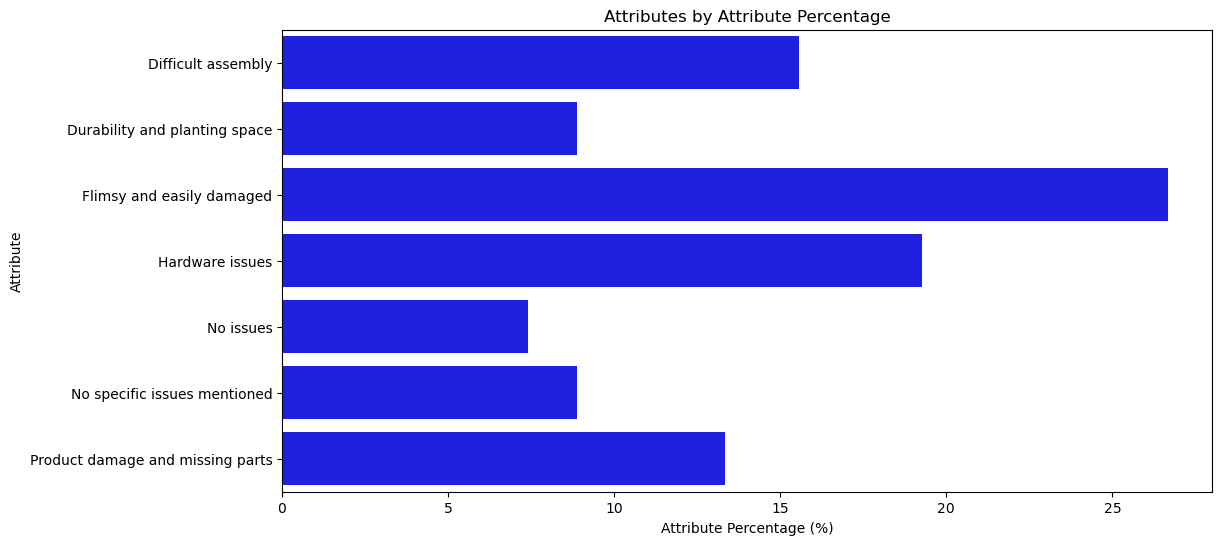

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=attributes[attributes['Attribute'] ==   'Issues']['attribute_percentage'], y=attributes[attributes['Attribute'] == 'Issues']['cluster_label'], data=attributes, ci=None, color='b')
plt.xlabel('Attribute Percentage (%)')
plt.ylabel('Attribute')
plt.title('Attributes by Attribute Percentage')
plt.show()

/var/folders/f6/0jn5yf2x1b319g8j96pnjbwh0000gn/T/ipykernel_54099/3117114536.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=attributes[attributes['Attribute'] ==   'Issues']['observation_count'], y=attributes[attributes['Attribute'] == 'Issues']['cluster_label'], data=attributes, ci=None, color='b')


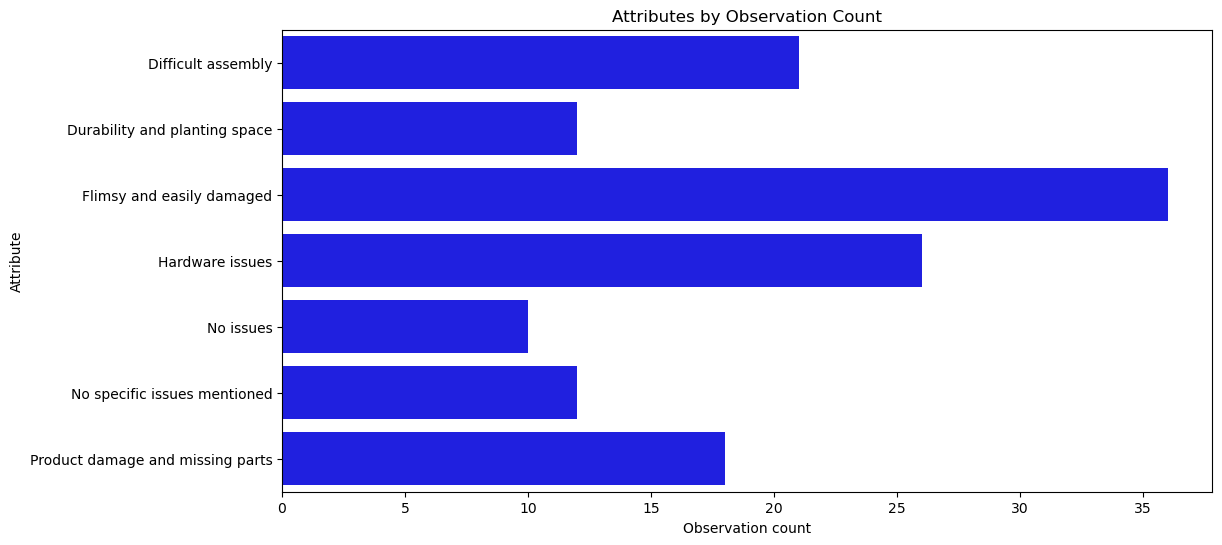

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=attributes[attributes['Attribute'] ==   'Issues']['observation_count'], y=attributes[attributes['Attribute'] == 'Issues']['cluster_label'], data=attributes, ci=None, color='b')
plt.xlabel('Observation count')
plt.ylabel('Attribute')
plt.title('Attributes by Observation Count')
plt.show()

In [19]:
reviews_with_clusters.columns

Index(['Unnamed: 0', 'Rating', 'URL', 'positive_sentiment',
       'negative_sentiment', 'asin', 'id', 'Review Summary', 'Attribute',
       'Value', 'cluster', 'cluster_label', 'Date', 'Author', 'Verified',
       'Helpful', 'Title', 'review', 'Images', 'Videos', 'Variation', 'Style'],
      dtype='object')

In [21]:
set(attributes[attributes['Attribute'] == 'Issues']['cluster_label'])

{'Difficult assembly',
 'Durability and planting space',
 'Flimsy and easily damaged',
 'Hardware issues',
 'No issues',
 'No specific issues mentioned',
 'Product damage and missing parts'}

In [25]:
set(reviews_with_clusters.loc[(reviews_with_clusters['Attribute'] == 'Issues') & (reviews_with_clusters['cluster_label'] == 'Flimsy and easily damaged'), 'Value'])

{'1. Flimsy and not durable. 2. Evaporation is a big problem due to thinness.',
 'Actual dimensions were smaller than expected',
 'Bent panels and difficult assembly, may not last long',
 'Concerned about bowing',
 'Damaged panel and lack of customer service',
 'Flimsy and mislabeled panels',
 'Holes misaligned, paint easily scratched',
 "I wish it would stay its rectangular shape and not morph around easily when it's not filled",
 'Many of my panels were bent',
 "Metals don't match and panels cannot be switched. Plastic coating was difficult to remove.",
 'Middle brackets are not long enough and bends in the one side had to make our own brackets',
 'Missing main support pieces',
 'Missing nuts and bolts, sharp edges',
 'Needs more support on the 8-foot side',
 'No noticeable bowing',
 'One of the beds had a dented corner piece',
 'One panel is bulging in the center',
 'Product needs to be fixed with new bars and filled-in holes',
 'Protective plastic was difficult to remove',
 'Some i

In [26]:
general_product_data

{'Product Summary': 'The Raised Garden Bed is a 6x3x2ft galvanized planter box designed for growing vegetables, flowers, and herbs. It is made of stable thickened steel with an evaluated coating paint, ensuring long-term use without rusting. The open bottom design allows for good drainage, promoting healthy plant growth. Setting up the garden bed is quick and easy, as it does not require any tools. The butterfly screws provided can be fastened by hand in just 5-10 minutes. The garden bed also features a cured edge for safety, preventing any injuries to your hands.',
 'In_the_Box': 'The package includes the FRIZIONE Galvanized Metal Raised Garden Bed and all the necessary hardware for assembly.',
 'technical_facts': 'The garden bed is made of galvanized steel with an anti-rust coating. It has a 2ft depth and measures 6x3ft in size.',
 'features': '1. Size: 6x3x2ft, providing ample growing space for vegetables, herbs, and flowers.\n2. Made of stable thickened steel with evaluated coating

In [71]:
problem_statement_function = [
    {
        "name": "problem_statement_function",
        "description": """This function is designed to isolate and describe a singular, primary issue with a product being sold on Amazon, using the data from customer complaints and the product's description. 
        Example Output:     
            "problem_identification": "Lack of durability and insufficient planting space",
            "problem_statement": "The garden beds are perceived as flimsy and require additional support. They also appear to provide less planting space than customers expected.",
            "customer_voice_examples": [
                "The garden beds are flimsy and require additional support with wood framing.", 
                "Wished for more room for additional grow beds", 
                "Oval-shaped box loses a little planting space, but not worried about it at this time"
                ]""",
        "parameters": {
            "type": "object",
            "properties": {
                "problem_identification": {
                    "type": "string",
                    "description": "From the given data, identify and articulate the key problem or issue with the product." 
                },
                "problem_statement": {
                    "type": "string",
                    "description": "Elaborate on the identified problem, providing a detailed statement based on the observations made. This should be within a range of 200 words." 
                },
                "customer_voice_examples": {
                    "type": "string",
                    "description": "Select and provide quotes from customer complaints which further detail the problem and illustrate its impact. This should be up to 10 examples and within a range of 10 - 200 words." 
                },
            },
            "required": ["problem_identification", "problem_statement", "customer_voice_examples"]
        }
    }
]

In [58]:
product_description = general_product_data

In [59]:
product_issues_list = list(set(attributes[attributes['Attribute'] == 'Issues']['cluster_label']))

In [60]:
product_issues_list

['Durability and planting space',
 'No issues',
 'Difficult assembly',
 'No specific issues mentioned',
 'Hardware issues',
 'Flimsy and easily damaged',
 'Product damage and missing parts']

In [61]:
# product_issues_list.pop(1)

'No issues'

In [62]:
for issue in product_issues_list:
    customer_voice_examples = list(set(reviews_with_clusters.loc[(reviews_with_clusters['Attribute'] == 'Issues') & (reviews_with_clusters['cluster_label'] == issue), 'Value']))
    print (issue)
    print (customer_voice_examples)

Durability and planting space
['Look forward to out above ground gardening', 'I was able to plant 6 tomato plants and 4 pepper plants with no issue', 'We plan to add more next year', 'Hope it lasts a couple of seasons', "Haven't planted yet", 'The garden beds are flimsy and require additional support with wood framing.', 'Not tested for longevity yet', "Won't know about durability for a while", 'Wished for more room for additional grow beds', 'Oval-shaped box loses a little planting space, but not worried about it at this time', 'I have purchased 4 so far', 'Next season will probably determine how long']
Difficult assembly
['Difficult to assemble, flimsy materials', 'Difficult to assemble, ended up in the landfill', 'Assembling this thing by yourself is time consuming and it is not too sturdy.', 'Screws were burred and difficult to start by hand. Assembly requires two people and takes a couple of hours. Directions are almost nonexistent.', 'Just took a long time to assemble', "Assembly

In [72]:
problem_statements = []
for issue in product_issues_list:
    customer_voice_examples = list(set(reviews_with_clusters.loc[(reviews_with_clusters['Attribute'] == 'Issues') & (reviews_with_clusters['cluster_label'] == issue), 'Value']))

    messages = [
        {"role": "user", "content": f"ISSUE {issue} CUSTOMER VOICE EXAMPLES: {customer_voice_examples} AND PRODUCT DESCRIPTION: {product_description}"}
    ]

    # Send the request to the LLM and get the response
    response =  chat_completion_request(
        messages=messages,
        functions=problem_statement_function,
        function_call={"name": "problem_statement_function"},
        temperature=0,
        model=GPT_MODEL
    )

    # Process the response and store in the dictionary
    chat_response = response.json()["choices"][0]
    problem_statements.append(chat_response)

In [73]:
df_problem_statements = pd.DataFrame(product_issues_list, columns=['cluster_label'])
df_problem_statements['Attribute'] = 'Issues'
df_problem_statements

,cluster_label,Attribute
0,Durability and planting space,Issues
1,Difficult assembly,Issues
2,No specific issues mentioned,Issues
3,Hardware issues,Issues
4,Flimsy and easily damaged,Issues
5,Product damage and missing parts,Issues


In [74]:
eval_responses = []
for item in problem_statements:
    data = item['message']['function_call']['arguments']
    # Replace 'null' with 'None' in the data string before evaluation
    data = data.replace('null', 'None')
    eval_data = eval(data)
    eval_responses.append(eval_data)

df_problem_statements['problem_statement'] = eval_responses

In [75]:
df_problem_statements_path = '/Users/vladbordei/Documents/Development/ProductExplorer/data/interim/problem_statements.csv'
df_problem_statements.to_csv(df_problem_statements_path, index = False)